In [1]:
#!pip install gp_emulator



In [2]:
import numpy as np
import gp_emulator
import matplotlib.pyplot as plt
import prosail

I could nout install  prosail in python3.6
and just took the libraries to call them.

Below the  scaling-transform functions according
to https://github.com/jgomezdans/gp_emulator/blob/master/notebooks/Emulation_playground.ipynb

In [3]:
def inverse_transform(x):
    """Inverse transform the PROSAIL parameters"""
    x_out = x * 1.
    # Cab, posn 1
    x_out[1] = -100. * np.log(x[1])
    # Cab, posn 2
    x_out[2] = -100. * np.log(x[2])
    # Cw, posn 4
    x_out[4] = (-1. / 50.) * np.log(x[4])
    # Cm, posn 5
    x_out[5] = (-1. / 100.) * np.log(x[5])
    # LAI, posn 6
    x_out[6] = -2. * np.log(x[6])
    # ALA, posn 7
    x_out[7] = 90. * x[7]
    return x_out


def transform(x):
    """ transform the PROSAIL parameters"""
    x_out = np.asarray(x) * 1.
    # Cab, posn 1
    x_out[1] = np.exp(-x[1] / 100)
    # Cab, posn 2
    x_out[2] = np.exp(-x[2] / 100)
    # Cw, posn 4
    x_out[4] = np.exp(-50. * x[4])
    # Cm, posn 5
    x_out[5] = np.exp(-50. * x[5])
    # LAI, posn 6
    x_out[6] = np.exp(-x[6] / 2.)
    # ALA, posn 7
    x_out[7] = x[7] / 90.
    return x_out


An input vector with average PROSAIL paremeters
(based on Table 1 in  https://www.mdpi.com/2072-4292/8/2/119)
is defined as:

In [7]:
p = {'n': (2.5 - 0.8) / 2,
         'cab': (77 - 0.2) / 2,
         'car': (15 / 2.),
         'csen': 1 / 2.,
         'cw': (0.0753 - 0.0043) / 2,
         'cm': (0.0331 - 0.0017) / 2,
         'lai': 8 / 2,
         'ala': 90 / 2,
         'hspot': 0,
         'bsoil': (1 - (-0.5)) / 2,
         'psoil': (1 - (-0.5)) / 2}


I select a random emulator file from

In [5]:
fname = '/data/WET_03/TEMP/leon/gps/emulators/spectral/prosail/prosail_020_000_0060.npz'
sza, vza, raa = 20., 0.0, 60


We pass the x vector to PROSAIL to obtain the simulated
 surface reflectance spectrum.

Text(0, 0.5, 'PROSAIL simulated surface reflectance')

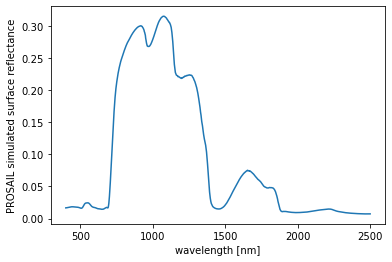

In [9]:
surf_refl = prosail.run_prosail(p['n'], p['cab'], p['car'],
                                    p['csen'], p['cw'], p['cm'],
                                    p['lai'], p['ala'],
                                    p['hspot'],
                                    sza, vza, raa,
                                    rsoil=p['bsoil'],
                                    psoil=p['psoil'],
                                    )

wavelength = np.arange(400, 2501, 1)

plt.plot(wavelength, surf_refl,label='PROSAIL')
plt.xlabel('wavelength [nm]')
plt.ylabel('PROSAIL simulated surface reflectance')

Now we would like to compare the PROSAIL output with the prediction
from the gp_emulator

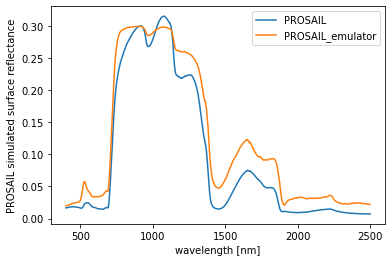

In [11]:
gp = gp_emulator.MultivariateEmulator(dump=fname)

x_gp = [p['n'], p['cab'], p['car'], p['cw'],
        p['cm'], p['lai'], p['ala'],
        p['hspot'],
        p['bsoil'], p['psoil']]

x_transformed = transform(x_gp)
y_pred, y_sigma, y_grad = gp.predict(x_transformed)

plt.plot(wavelength, surf_refl,label='PROSAIL')
plt.plot(wavelength, y_pred,label='PROSAIL_emulator')
plt.xlabel('wavelength [nm]')
plt.ylabel('PROSAIL simulated surface reflectance')
plt.legend()